# Backend Results

## Experiment 1 
- Seeing which algorithm converges faster given a particular unitary size and given resolution 
- Resolution ranges from [10,50] with a changed of 5 in between 
- Max iterations is 10 and error threshold is $10^{-3}$

In [1]:
resolutions = [i for i in range(10, 55, 5)]
resolutions

[10, 15, 20, 25, 30, 35, 40, 45, 50]

In [2]:
from qiskit import IBMQ
from qiskit import QuantumCircuit, execute, transpile, Aer
from qiskit.extensions import UnitaryGate, Initialize
from qiskit.quantum_info import Statevector
from qiskit.compiler import assemble 
from qiskit.tools.visualization import plot_bloch_vector
from qiskit.tools.visualization import plot_histogram, plot_bloch_multivector
import numpy as np
from time import sleep
import sys
import os
from scipy.stats import unitary_group
import matplotlib.pyplot as plt
%matplotlib inline

# IBMQ.load_account()
# provider = IBMQ.get_provider(hub='ibm-q-education')
# santiago = provider.get_backend('ibmq_santiago')
# casablanca = provider.get_backend('ibmq_casablanca')
# bogota = provider.get_backend('ibmq_bogota')
sim = Aer.get_backend('qasm_simulator')
# athens = provider.get_backend('ibmq_athens')

In [4]:
from normal_SPEA import SPEA
from bundled_global_max_alt_SPEA import bundled_SPEA_alternate

### Utils

In [5]:
def generate_plots(unitary_size, costs, errors, overlaps, algorithm):
    import random
    colors = ['red', 'brown', 'cyan', 'green',
              'grey', 'blue', 'purple', 'black', 'orange']
    c1, c2, c3 = random.sample(colors, 3)

    # plot
    os.makedirs("Experiment_1/"+str(unitary_size) +
                "_qubit(random)(backend)/", exist_ok=True)
    # plot 1
    fig = plt.figure(figsize=(13, 6))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.set_title(str(unitary_size)+" qubit "+algorithm +
                  " Cost v/s Max iters", fontsize=16)
    ax1.set_xlabel("Number of Resolutions ", fontsize=15)
    ax1.set_ylabel("Metrics Returned for unitary ", fontsize=15)
    ax1.plot(resolutions, costs, label='Costs of Unitary',
             marker='o', color=c1, alpha=0.7)
    ax1.plot(resolutions, overlaps, label='Average overlap from nearest eigenvector',
             marker='s', color=c2, alpha=0.6)
    ax1.legend(loc='best')
    ax1.grid()
    # plot 2
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.set_title(str(unitary_size)+" qubit "+algorithm +
                  " % error v/s Max iters", fontsize=16)
    ax2.set_xlabel("Number of resolutions ", fontsize=15)
    ax2.set_ylabel("% error for nearest eigenvalue", fontsize=15)
    ax2.plot(resolutions, errors, label='Average error from nearest eigenvalue',
             marker='o', color=c3, alpha=0.6)
    ax2.legend(loc='best')
    ax2.grid()
    # save axure
    fig.savefig("Experiment_1/"+str(unitary_size)+"_qubit(random)(backend)/" +
                algorithm+" Algorithm (alternate).JPG", dpi=200)

In [24]:
def get_results(eig_vals, eig_vect, basis, basis_ind, unitary, algorithm, experiments):
    '''Return the results of running the algorithm for this particular unitary matrix'''
    costs_g = []
    errors_g = []
    max_overlaps_g = []
    # find how the cost converges with increasing iterations
    for reso in resolutions:
        costs = []
        errors = []
        overlaps = []
        # run the experiments ...
        while len(costs) < experiments:
            if algorithm == 'original':
                spea = SPEA(unitary, resolution=reso, error=3, max_iters=12)
            else:
                spea = bundled_SPEA_alternate(
                    unitary, resolution=reso, error=3, max_iters=12)

            result = spea.get_eigen_pair(
                progress=False,backend=sim, algo='alternate', basis=basis, basis_ind=basis_ind,
                randomize=False,shots=256)

            if result['cost'] < 0.75:
                continue
            # find the costs
            costs.append(result['cost'])
            theta = result['theta']
            res_state = result['state']

            # find the abs difference in this theta with the closest eigenvalue
            # and append that to the errors ...
            min_error = 1e5
            for e in eig_vals:
                error = abs(e - theta)
                if error < min_error:
                    min_error = error
                    perc_error = ((error)/e)*100
            errors.append(perc_error)

            # find overlaps
            max_overlap = -1
            for k in eig_vect:
                dot = np.linalg.norm(np.dot(k, res_state.conjugate().T))**2
                max_overlap = max(max_overlap, dot)
            overlaps.append(max_overlap)

        print("Result with", reso, " resolutions :")
        print("AVG. COST :", np.average(costs),
              "AVG. ERROR :", np.average(errors))
        # append the average result of your algorithm ...
        costs_g.append(np.average(costs))
        errors_g.append(np.average(errors))
        max_overlaps_g.append(np.average(overlaps))

    return costs_g, errors_g, max_overlaps_g

## 1 - qubit unitary

In [25]:
unit = unitary_group.rvs(2)
unit

array([[-0.33535542+0.18840125j,  0.86623631-0.31886731j],
       [ 0.68079948+0.62334082j,  0.23895108+0.30143103j]])

In [26]:
eig_vals1, eig_vect1 = np.linalg.eig(unit)
eig_vals1 = np.angle(eig_vals1)
e = []
for k in eig_vals1:
    if k < 0:
        v = (k + 2*np.pi)/(2*np.pi)
    else:
        v = (k)/(2*np.pi)
    e.append(v)
eig_vals1 = np.array(e)
print("Eigenstates :", eig_vect1)
print("Eigenvalues :", eig_vals1)

Eigenstates : [[ 0.80691658+0.j          0.50446816-0.30724176j]
 [-0.50446816-0.30724176j  0.80691658+0.j        ]]
Eigenvalues : [0.4907762  0.07108008]


### Generate basis

In [27]:
sample1 = unitary_group.rvs(2)
print(sample1)
basis1 = []
for k in sample1:
    basis1.append(np.array(k,dtype=complex)) 
print("1 qubit basis :",basis1)
ind1 = np.random.choice(range(2))
print(ind1)

[[ 0.06925765+0.16688127j -0.6034742 -0.77664208j]
 [-0.10400468-0.97802712j -0.06586606-0.16824875j]]
1 qubit basis : [array([ 0.06925765+0.16688127j, -0.6034742 -0.77664208j]), array([-0.10400468-0.97802712j, -0.06586606-0.16824875j])]
1


### Algorithm 1

In [28]:
costs_1qubit_b, errors_eig_1qubit_b, max_overlaps_1qubit_b = get_results(
    eig_vals1, eig_vect1,basis1, ind1, unit, 'original', 4)

Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Result with 10  resolutions :
AVG. COST : 0.8779296875 AVG. ERROR : 76.2637450345453
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Result with 15  resolutions :
AVG. COST : 0.9755859375 AVG. ERROR : 30.91214242140923
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the es

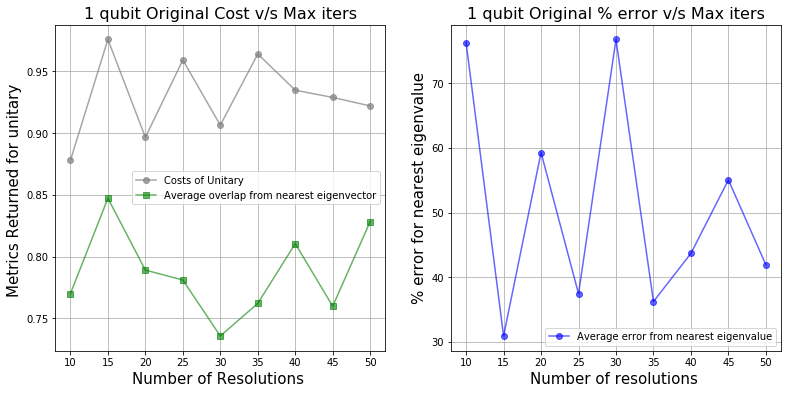

In [29]:
generate_plots(1, costs_1qubit_b, errors_eig_1qubit_b,
               max_overlaps_1qubit_b, "Original")

### Algorithm 2

PHI : [-0.66607896+0.2169937j   0.71331421+0.02086617j]
Maximum iterations reached for the estimation.
Terminating algorithm...
PHI : [-0.66607896+0.2169937j   0.71331421+0.02086617j]
Maximum iterations reached for the estimation.
Terminating algorithm...
PHI : [-0.66607896+0.2169937j   0.71331421+0.02086617j]
Maximum iterations reached for the estimation.
Terminating algorithm...
PHI : [-0.66607896+0.2169937j   0.71331421+0.02086617j]
Maximum iterations reached for the estimation.
Terminating algorithm...
Result with 10  resolutions :
AVG. COST : 0.8720703125 AVG. ERROR : 15.889275196680606
PHI : [-0.66607896+0.2169937j   0.71331421+0.02086617j]
Maximum iterations reached for the estimation.
Terminating algorithm...
PHI : [-0.66607896+0.2169937j   0.71331421+0.02086617j]
Maximum iterations reached for the estimation.
Terminating algorithm...
PHI : [-0.66607896+0.2169937j   0.71331421+0.02086617j]
Maximum iterations reached for the estimation.
Terminating algorithm...
PHI : [-0.6660789

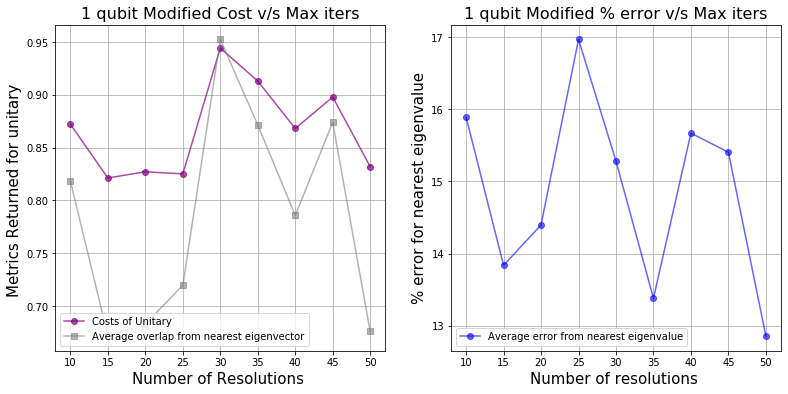

In [12]:
costs_1qubit_c, errors_eig_1qubit_c, max_overlaps_1qubit_c = get_results(
    eig_vals1, eig_vect1, basis1, ind1, unit, 'modified', 4)
generate_plots(1, costs_1qubit_c, errors_eig_1qubit_c,
               max_overlaps_1qubit_c, "Modified")

## 2 - qubit unitary


In [13]:
unit_2 = unitary_group.rvs(4)
unit_2

array([[ 0.40913208+0.03579906j,  0.07541184-0.27570804j,
        -0.6508013 -0.05711413j,  0.42061369-0.3819781j ],
       [-0.46945741+0.17284398j, -0.16568387+0.47936271j,
        -0.51785293+0.3511179j ,  0.23078196+0.21858454j],
       [ 0.46283095+0.12082561j,  0.07328344-0.21927979j,
        -0.22203086+0.31953793j, -0.28497956+0.69650488j],
       [ 0.42338711-0.41592801j,  0.2713569 +0.73073232j,
        -0.08282425-0.15322585j, -0.09892781-0.0042692j ]])

In [14]:
eig_vals2, eig_vect2 = np.linalg.eig(unit_2)
eig_vals2 = np.angle(eig_vals2)
e = []
for k in eig_vals2:
    if k < 0:
        v = (k + 2*np.pi)/(2*np.pi)
    else:
        v = (k)/(2*np.pi)
    e.append(v)
eig_vals2 = np.array(e)
print("Eigenstates :", eig_vect2)
print("Eigenvalues :", eig_vals2)

Eigenstates : [[ 0.70998499+0.j         -0.26241285-0.12070923j -0.09327575-0.54458223j
  -0.13980163+0.29610034j]
 [-0.10008035-0.13271743j -0.53016371+0.14110514j  0.65442879+0.j
   0.43195519+0.23774661j]
 [-0.14541069+0.36708801j -0.1243558 -0.51105682j -0.36574619-0.11996052j
   0.64753215+0.j        ]
 [ 0.55222424-0.08626603j  0.5821865 +0.j          0.25756735+0.22792771j
   0.47242659-0.08477371j]]
Eigenvalues : [0.89509573 0.56528866 0.18214624 0.30938693]


### Generate Basis

In [15]:
sample2 = unitary_group.rvs(4)
print(sample2)
basis2 = []
for k in sample2:
    basis2.append(np.array(k,dtype=complex)) 
print("2 qubit basis :",basis2)
ind2 = np.random.choice(range(4))
print(ind2)

[[ 0.26586186-0.36542764j -0.63644288+0.27249758j -0.07438381+0.18846829j
  -0.09822282+0.51552369j]
 [-0.74103584+0.17963925j -0.36972633-0.03217428j -0.0526149 +0.45808384j
  -0.21648239-0.1462502j ]
 [-0.18779751+0.22009031j -0.18615085+0.39388761j -0.54950826-0.64117233j
  -0.10457087-0.04996402j]
 [ 0.19660101-0.3033416j   0.05665179+0.43582539j  0.16054132+0.08661878j
  -0.5440401 -0.58900149j]]
2 qubit basis : [array([ 0.26586186-0.36542764j, -0.63644288+0.27249758j,
       -0.07438381+0.18846829j, -0.09822282+0.51552369j]), array([-0.74103584+0.17963925j, -0.36972633-0.03217428j,
       -0.0526149 +0.45808384j, -0.21648239-0.1462502j ]), array([-0.18779751+0.22009031j, -0.18615085+0.39388761j,
       -0.54950826-0.64117233j, -0.10457087-0.04996402j]), array([ 0.19660101-0.3033416j ,  0.05665179+0.43582539j,
        0.16054132+0.08661878j, -0.5440401 -0.58900149j])]
0



### Algorithm 1

Phi: [ 0.26586186-0.36542764j -0.63644288+0.27249758j -0.07438381+0.18846829j
 -0.09822282+0.51552369j]
Maximum iterations reached for the estimation.
Terminating algorithm...
Phi: [ 0.26586186-0.36542764j -0.63644288+0.27249758j -0.07438381+0.18846829j
 -0.09822282+0.51552369j]
Maximum iterations reached for the estimation.
Terminating algorithm...
Phi: [ 0.26586186-0.36542764j -0.63644288+0.27249758j -0.07438381+0.18846829j
 -0.09822282+0.51552369j]
Maximum iterations reached for the estimation.
Terminating algorithm...
Phi: [ 0.26586186-0.36542764j -0.63644288+0.27249758j -0.07438381+0.18846829j
 -0.09822282+0.51552369j]
Maximum iterations reached for the estimation.
Terminating algorithm...
Result with 10  resolutions :
AVG. COST : 0.9365234375 AVG. ERROR : 4.3246775832980155
Phi: [ 0.26586186-0.36542764j -0.63644288+0.27249758j -0.07438381+0.18846829j
 -0.09822282+0.51552369j]
Maximum iterations reached for the estimation.
Terminating algorithm...
Phi: [ 0.26586186-0.36542764j -0.

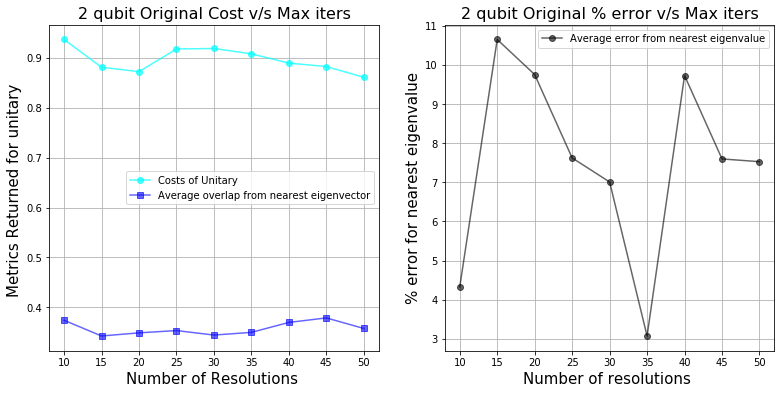

In [16]:
costs_2qubit_b, errors_eig_2qubit_b, max_overlaps_2qubit_b = get_results(
    eig_vals2, eig_vect2, basis2, ind2, unit_2, 'original', 4)
generate_plots(2, costs_2qubit_b, errors_eig_2qubit_b,
               max_overlaps_2qubit_b, "Original")

### Algorithm 2

PHI : [ 0.26586186-0.36542764j -0.63644288+0.27249758j -0.07438381+0.18846829j
 -0.09822282+0.51552369j]
Maximum iterations reached for the estimation.
Terminating algorithm...
PHI : [ 0.26586186-0.36542764j -0.63644288+0.27249758j -0.07438381+0.18846829j
 -0.09822282+0.51552369j]
Maximum iterations reached for the estimation.
Terminating algorithm...
PHI : [ 0.26586186-0.36542764j -0.63644288+0.27249758j -0.07438381+0.18846829j
 -0.09822282+0.51552369j]
Maximum iterations reached for the estimation.
Terminating algorithm...
PHI : [ 0.26586186-0.36542764j -0.63644288+0.27249758j -0.07438381+0.18846829j
 -0.09822282+0.51552369j]
Maximum iterations reached for the estimation.
Terminating algorithm...
Result with 10  resolutions :
AVG. COST : 0.90234375 AVG. ERROR : 9.854989135045784
PHI : [ 0.26586186-0.36542764j -0.63644288+0.27249758j -0.07438381+0.18846829j
 -0.09822282+0.51552369j]
Maximum iterations reached for the estimation.
Terminating algorithm...
PHI : [ 0.26586186-0.36542764j 

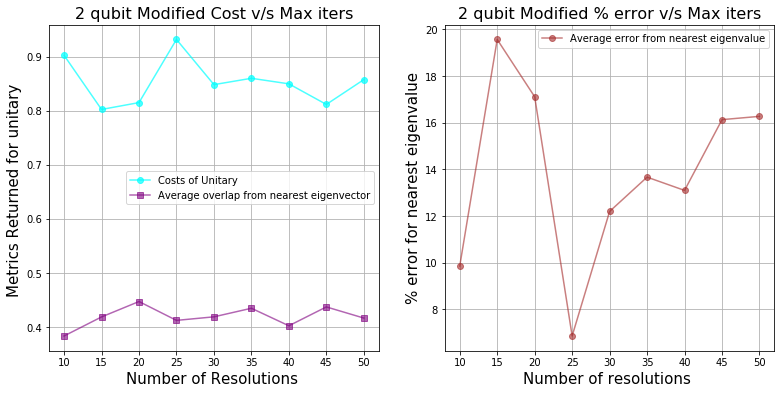

In [17]:
costs_2qubit_c, errors_eig_2qubit_c, max_overlaps_2qubit_c = get_results(
    eig_vals2, eig_vect2, basis2, ind2, unit_2, 'modified', 4)
generate_plots(2, costs_2qubit_c, errors_eig_2qubit_c,
               max_overlaps_2qubit_c, "Modified")

## 3 - qubit unitary

In [30]:
unit_3 = unitary_group.rvs(8)
unit_3

array([[ 0.47777076+0.28744312j, -0.0978045 -0.15320067j,
         0.13612682+0.0864557j , -0.03736529+0.2514528j ,
        -0.25996035+0.13701622j, -0.01729151-0.19314694j,
         0.57124389-0.23013807j, -0.24015576+0.06730639j],
       [-0.24982007+0.18985901j, -0.29648411+0.33442437j,
        -0.01749636-0.32996174j,  0.0078571 +0.03297437j,
        -0.28139132+0.25388971j, -0.07124761-0.22941164j,
        -0.01467723-0.20734504j,  0.18875472-0.55793222j],
       [ 0.07661344+0.24430515j, -0.20256713-0.34316937j,
        -0.34066301+0.13476242j, -0.04082704+0.26946289j,
         0.03987111+0.49588304j,  0.09161999+0.38256955j,
        -0.16109137+0.08185655j,  0.36243341+0.03008545j],
       [ 0.27885805+0.1969512j , -0.17033557+0.35968426j,
         0.0498281 +0.24817352j,  0.0493131 -0.30113444j,
        -0.41678435+0.10693985j,  0.08275623-0.20503826j,
        -0.36530597+0.25532326j,  0.08293441+0.35822289j],
       [-0.283094  -0.04715866j, -0.13192598-0.43004184j,
         0

In [31]:
eig_vals3, eig_vect3 = np.linalg.eig(unit_3)
eig_vals3 = np.angle(eig_vals3)
e = []
for k in eig_vals3:
    if k < 0:
        v = (k + 2*np.pi)/(2*np.pi)
    else:
        v = (k)/(2*np.pi)
    e.append(v)
eig_vals3 = np.array(e)
print("Eigenstates :", eig_vect3)
print("Eigenvalues :", eig_vals3)

Eigenstates : [[ 0.61383813+0.j         -0.05814477-0.0219199j  -0.48884258+0.14236145j
   0.35560747-0.02725232j -0.32207746-0.08606266j -0.22032611+0.09721024j
  -0.01625627+0.14114773j  0.15778119+0.13671975j]
 [-0.05939596+0.01424378j -0.24210878-0.12830284j  0.05039442-0.04712949j
  -0.27036254+0.45830427j -0.38027242+0.2196691j   0.28520362-0.02704217j
  -0.13127943+0.2614482j   0.52227196+0.j        ]
 [-0.15820829+0.21012125j -0.29290809-0.1499455j  -0.11348121+0.2916986j
   0.22640011-0.10439686j  0.08206877-0.29053108j  0.24326372+0.18791235j
  -0.48503921-0.20477788j  0.0891726 -0.43776474j]
 [-0.02213749+0.15820307j  0.66464403+0.j         -0.06543522+0.39850294j
  -0.02677328+0.11679707j -0.27454238-0.10827627j  0.20278597-0.38232757j
   0.09651847-0.21383846j  0.07361673-0.14293146j]
 [-0.11243913+0.00466734j  0.02731213+0.32021865j  0.52459085+0.j
   0.5545346 +0.j         -0.09992331-0.1287409j  -0.03041687-0.02758373j
  -0.13155064-0.10637676j  0.33161842+0.36675365j]


### Generate Basis

In [32]:
sample3 = unitary_group.rvs(8)
# print(sample3)
basis3 = []
for k in sample3:
    basis3.append(np.array(k,dtype=complex)) 
print("3 qubit basis :",basis3)
ind3 = np.random.choice(range(8))
print(ind3)

3 qubit basis : [array([-0.35642039-0.39285719j, -0.16882515-0.12782415j,
       -0.32910459+0.13664071j, -0.0836015 -0.5560188j ,
        0.11203368+0.13402969j,  0.13374111-0.26698073j,
       -0.05998458+0.12740123j,  0.12930587-0.27281868j]), array([-0.22201624-0.34055959j,  0.30605811+0.34289436j,
        0.29691294+0.29514723j,  0.14742677+0.00747977j,
        0.33486755-0.12738825j,  0.16266994+0.16735587j,
        0.36953886-0.23690994j,  0.21706006+0.06153182j]), array([ 0.25625475-0.10910933j,  0.09674866+0.09539155j,
       -0.02270754+0.20832235j, -0.414973  -0.20769383j,
       -0.5685212 +0.13981601j, -0.15465682+0.00100845j,
        0.09018049-0.44825798j,  0.25755107+0.05129084j]), array([ 0.31590005-0.13243755j,  0.09983574-0.34858129j,
        0.25518999+0.3927277j , -0.02595457+0.11005796j,
        0.04447716-0.35553958j, -0.21024736-0.21380621j,
       -0.12571217+0.37434026j,  0.35926376-0.125458j  ]), array([ 0.31726   +0.06699767j, -0.1500964 +0.45519937j,
      

- Algorithm 1

In [ ]:
costs_3qubit_b, errors_eig_3qubit_b, max_overlaps_3qubit_b = get_results(
    eig_vals3, eig_vect3, basis3, ind3, unit_3, 'original', 4)

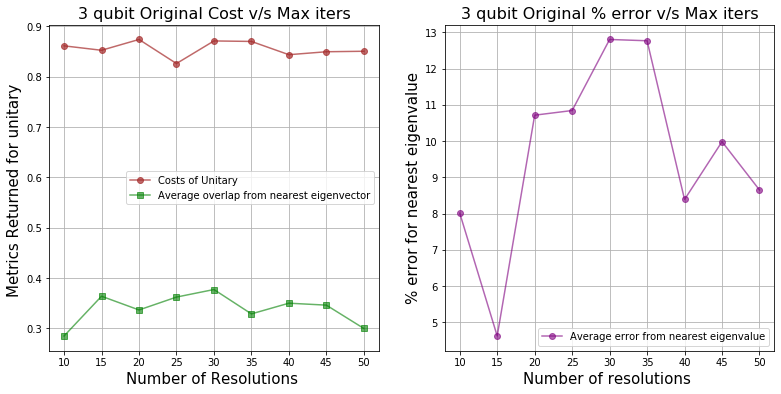

In [34]:
generate_plots(3, costs_3qubit_b, errors_eig_3qubit_b,
               max_overlaps_3qubit_b, "Original")

- Algorithm 2

In [ ]:
costs_3qubit_c, errors_eig_3qubit_c, max_overlaps_3qubit_c = get_results(
    eig_vals3, eig_vect3, basis3, ind3, unit_3, 'modified', 4)
generate_plots(3, costs_3qubit_c, errors_eig_3qubit_c,
               max_overlaps_3qubit_c, "Modified")

## 4 - qubit unitary

In [ ]:
unit_4 = unitary_group.rvs(16)
unit_4

- Algorithm 1

In [ ]:
costs = []
thetas = []
# find how the cost converges with increasing resolution
for res in resolutions:
    spea = SPEA(unit_4, resolution=res, error=3, max_iters=10)
    result = spea.get_eigen_pair(progress=False, backend=casablanca)
    print("Result with", res, " resolution :", result)
    costs.append(result['cost'])
    thetas.append(result['theta'])
# plot
plt.title("4-qubit(basic) unitary cost v/s resolution", fontsize=16)
plt.xlabel("Resolution ", fontsize=15)
plt.ylabel("Cost Returned for unitary ", fontsize=15)
plt.plot(resolutions, costs, label='Costs of unitary',
         marker='s', color='red', alpha=0.5)
plt.plot(resolutions, thetas, label='Eigenvalues',
         marker='o', color='cyan', alpha=0.5)
plt.legend()
plt.grid()
os.makedirs("SPE/Experiment_1/4_qubit/", exist_ok=True)
plt.savefig("SPE/Experiment_1/4_qubit/Basic Algorithm Result", dpi=200)

- Algorithm 2

In [ ]:
costs = []
thetas = []
# find how the cost converges with increasing resolution
for res in resolutions:
    spea = global_max_SPEA(unit_4, resolution=res, error=3, max_iters=10)
    result = spea.get_eigen_pair(progress=False, backend=casablanca)
    print("Result with", res, " resolution :", result)
    costs.append(result['cost'])
    thetas.append(result['theta'])

# plot
plt.title("4-qubit(modified) unitary cost v/s resolution", fontsize=16)
plt.xlabel("Resolution ", fontsize=15)
plt.ylabel("Cost Returned for unitary ", fontsize=15)
plt.plot(resolutions, costs, label='Costs of unitary',
         marker='s', color='yellow', alpha=0.7)
plt.plot(resolutions, thetas, label='Eigenvalues',
         marker='o', color='brown', alpha=0.5)
plt.legend()
plt.grid()
os.makedirs("SPE/Experiment_1/4_qubit/", exist_ok=True)
plt.savefig("SPE/Experiment_1/4_qubit/Modified Algorithm Result", dpi=200)

In [ ]:
unit_5 = unitary_group.rvs(32)
unit_5

- Algorithm 1

In [ ]:
costs = []
# find how the cost converges with increasing resolution
for res in resolutions:
    spea = SPEA(unit_5, resolution=res, error=3, max_iters=10)
    result = spea.get_eigen_pair(progress=False, backend=casablanca)
    print("Result with", res, " resolution :", result)
    costs.append(result['cost'])

# plot
plt.title("5-qubit(basic) unitary cost v/s resolution", fontsize=16)
plt.xlabel("Resolution ", fontsize=15)
plt.ylabel("Cost Returned for unitary ", fontsize=15)
plt.plot(resolutions, costs, label='Costs of unitary',
         marker='s', color='b', alpha=0.5)
plt.legend()
plt.grid()
os.makedirs("SPE/Experiment_1/5_qubit/", exist_ok=True)
plt.savefig("SPE/Experiment_1/5_qubit/Basic Algorithm Result", dpi=200)

- Algorithm 2

In [ ]:
costs = []
# find how the cost converges with increasing resolution
for res in resolutions:
    spea = global_max_SPEA(unit_5, resolution=res, error=3, max_iters=10)
    result = spea.get_eigen_pair(progress=False, backend=casablanca)
    print("Result with", res, " resolution :", result)
    costs.append(result['cost'])

# plot
plt.title("5-qubit(basic) unitary cost v/s resolution", fontsize=16)
plt.xlabel("Resolution ", fontsize=15)
plt.ylabel("Cost Returned for unitary ", fontsize=15)
plt.plot(resolutions, costs, label='Costs of unitary',
         marker='s', color='magenta', alpha=0.5)
plt.legend()
plt.grid()
os.makedirs("SPE/Experiment_1/5_qubit/", exist_ok=True)
plt.savefig("SPE/Experiment_1/5_qubit/Modified Algorithm Result", dpi=200)